In [59]:
import os
from pathlib import Path
import pandas as pd
import spacy
import re
import codecs
import plotly.express as px
import sys
import matplotlib.pyplot as plt
sys.path.insert(1, "/home/phisinger/Programmieren/wahlprogramm_analyse/preprocessing")
from FileHandler import FileHandler

Matplotlib created a temporary cache directory at /tmp/matplotlib-za9ib418 because the default path (/home/phisinger/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Import text files

In [2]:
fh = FileHandler()
text_data = fh.open_txt_files("clean")

Read files from:  /home/phisinger/Programmieren/wahlprogramm_analyse/data/clean


## Load language spacy model
Give every word a class (noun, verb, etc).

In [3]:

# select pipeline for German
# choose between speed and accuracy
mode = "speed" # "accuracy"
if mode == "speed":
    nlp = spacy.load("de_core_news_sm")
    nlp.max_length = 200000
else:
    nlp = spacy.load("de_dep_news_trf")
nlp.max_length = 200000

## Analyze Nouns and store
Each word is now categroized and the nouns are visualized. Visualisations are stored.

In [23]:
path = "../analysis/most_used_words"
if not os.path.exists(path):
    os.mkdir(path)
for year in text_data.keys():
    for party in text_data[year].keys():
        text = text_data[year][party][0]
        tokens_list = []
        # analyze
        for num_chunks in range((len(text)//50000)+1):
            chunk = nlp(str(text[(num_chunks*50000):((1+num_chunks)*50000-1)]))
            for token in chunk:
                tokens_list.append({
                    "Text":     token.text,
                    "Lemma":    token.lemma_,
                    "POS":      token.pos_,
                    "Tag":      token.tag_,
                    "Dep":      token.dep_,
                    "Shape":    token.shape_,
                    "Alpha":    token.is_alpha, 
                    "Stop":     token.is_stop
                })
        print(f"Tokenization finsihed for {party} {year}")
        token_df = pd.DataFrame(tokens_list)
        
        nouns_df = token_df[token_df["POS"] == "PROPN"]
        # remove text that is wrongly assigned as nouns
        nouns_df = nouns_df[nouns_df["Lemma"] != "muss"]
        nouns_df = nouns_df[nouns_df["Lemma"] != "Muss"]
        important_nouns = nouns_df["Lemma"].value_counts()[0:21]
        # visualize
        fig = px.bar(important_nouns.sort_values(), x="count")
        # store
        fig.write_image(f"{path}/{party}_{year}.png")
        print(f"Digram stored for {party} {year}")

Tokenization finsihed for afd 2013
Digram stored for afd 2013
Tokenization finsihed for cdu 2013
Digram stored for cdu 2013
Tokenization finsihed for fdp 2013
Digram stored for fdp 2013
Tokenization finsihed for gruene 2013
Digram stored for gruene 2013
Tokenization finsihed for linke 2013
Digram stored for linke 2013
Tokenization finsihed for spd 2013
Digram stored for spd 2013
Tokenization finsihed for afd 2017
Digram stored for afd 2017
Tokenization finsihed for cdu 2017
Digram stored for cdu 2017
Tokenization finsihed for fdp 2017
Digram stored for fdp 2017
Tokenization finsihed for gruene 2017
Digram stored for gruene 2017
Tokenization finsihed for linke 2017
Digram stored for linke 2017
Tokenization finsihed for spd 2017
Digram stored for spd 2017
Tokenization finsihed for afd 2021
Digram stored for afd 2021
Tokenization finsihed for cdu 2021
Digram stored for cdu 2021
Tokenization finsihed for fdp 2021
Digram stored for fdp 2021
Tokenization finsihed for gruene 2021
Digram store

In [18]:
# Debugging
text = text_data["2017"]["gruene"][0]
tokens_list = []
for num_chunks in range((len(text)//50000)+1):
    chunk = nlp(str(text[(num_chunks*50000):((1+num_chunks)*50000-1)]))
    for token in chunk:
        tokens_list.append({
            "Text":     token.text,
            "Lemma":    token.lemma_,
            "POS":      token.pos_,
            "Tag":      token.tag_,
            "Dep":      token.dep_,
            "Shape":    token.shape_,
            "Alpha":    token.is_alpha, 
            "Stop":     token.is_stop
        })
print(f"Tokenization finsihed")
token_df = pd.DataFrame(tokens_list)

nouns_df = token_df[token_df["POS"] == "PROPN"]
# remove text that is wrongly assigned as nouns
nouns_df = nouns_df[nouns_df["Lemma"] != "muss"]
nouns_df = nouns_df[nouns_df["Lemma"] != "Muss"]
important_nouns = nouns_df["Lemma"].value_counts()[0:21]
print(important_nouns)
fig = px.bar(important_nouns.sort_values(), x="count")
fig.show()

Tokenization finsihed
Lemma
Deutschland          155
Europa                94
EU                    69
Afrika                11
Türkei                11
USA                    9
Paris                  8
baden-württemberg      6
Berlin                 6
vn                     6
Syrien                 5
Ceta                   5
Israel                 4
trans                  4
wto                    4
Nato                   4
OSZE                   4
trump                  4
Frankreich             4
Kitas                  4
180f                   4
Name: count, dtype: int64


## Generate a slopeplot to compare between parties
1. Sum word counts for all years per party
2. Select the words that are in all programs
3. Design the plot

In [60]:
# Sum word counts for all years per party

years = text_data.keys()
parties = text_data["2017"].keys()
slope_counts_dict = {}

for party in parties:
    party_text = ""
    # concatenate all years together
    for year in years:
        party_text += text_data[year][party][0] + "\n"
    # preprocessing for better comparability
    # replace the party name by a common placeholder: 
    
    tokens_list = []
    # analyze
    for num_chunks in range((len(party_text)//50000)+1):
        chunk = nlp(str(party_text[(num_chunks*50000):((1+num_chunks)*50000-1)]))
        for token in chunk:
            tokens_list.append({
                "Text":     token.text,
                "Lemma":    token.lemma_,
                "POS":      token.pos_,
                "Tag":      token.tag_,
                "Dep":      token.dep_,
                "Shape":    token.shape_,
                "Alpha":    token.is_alpha, 
                "Stop":     token.is_stop
            })
    print(f"Tokenization finsihed for {party}")
    token_df = pd.DataFrame(tokens_list)
    
    nouns_df = token_df[token_df["POS"] == "PROPN"]
    # remove text that is wrongly assigned as nouns
    nouns_df = nouns_df[nouns_df["Lemma"] != "muss"]
    nouns_df = nouns_df[nouns_df["Lemma"] != "Muss"]
    slope_counts_dict[party] = nouns_df["Lemma"].value_counts()[0:101]
    
        
    

Tokenization finsihed for afd
Tokenization finsihed for cdu
Tokenization finsihed for fdp
Tokenization finsihed for gruene
Tokenization finsihed for linke
Tokenization finsihed for spd


In [61]:
# debug 
# for party in parties:
#     fig = px.bar(slope_counts_dict[party].sort_values(), x="count", title=party, height=800)
#     fig.show()

In [62]:
# Replace names with function
slope_counts_dict_stndrdzd = slope_counts_dict.copy()
for party, element in slope_counts_dict_stndrdzd.items():
    lemma_list = element.index.to_list()
    if party == "gruene":
        self_list = ["grünen", "grüne"]
        foreign_list = ["spd", "cdu", "csu", "linke", "linken", "fdp", "afd"]
    if party == "spd":
        self_list = ["spd"]
        foreign_list = ["grünen", "grüne", "cdu", "csu", "linke", "linken", "fdp", "afd"]
    if party == "cdu":
        self_list = ["cdu", "csu"]
        foreign_list = ["grünen", "grüne", "spd", "linke", "linken", "fdp", "afd"]
    if party == "fdp":
        self_list = ["fdp"]
        foreign_list = ["grünen", "grüne", "spd", "linke", "linken", "cdu", "csu", "afd"]
    if party == "linke":
        self_list = ["linke", "linken"]
        foreign_list = ["grünen", "grüne", "spd", "fdp", "cdu", "csu", "afd"]
    if party == "afd":
        self_list = ["afd"]
        foreign_list = ["grünen", "grüne", "spd", "linke", "linken", "cdu", "csu", "fdp"]
    lemma_list = ["OWN PARTY" if lemma.lower() in self_list else lemma for lemma in lemma_list ]
    lemma_list = ["FOREIGN PARTY" if lemma.lower() in foreign_list else lemma for lemma in lemma_list ] 
    element.index = lemma_list
    slope_counts_dict_stndrdzd[party] = element

In [63]:
def find_common_elements(*lists):
    if not lists:
        return []
    
    # Convert each list to a set
    sets = [set(lst) for lst in lists[0]]

    # Find the intersection of all sets
    common_elements = set.intersection(*sets)

    return list(common_elements)

lemma_lists = []
for lemma_series in list(slope_counts_dict_stndrdzd.values()):
    lemma_lists.append(lemma_series.index.to_list())
common_elements = find_common_elements(lemma_lists)

# drop all indexes that are not present in common_elements
slope_counts_dict_cmmn = slope_counts_dict_stndrdzd.copy()
for party, lemma_series in slope_counts_dict.items():
    slope_counts_dict_cmmn[party] = lemma_series[lemma_series.index.isin(common_elements)]
    

In [64]:
list(slope_counts_dict_cmmn.values())[0]

Deutschland       248
Europa             55
EU                 53
ezb                24
Türkei             18
USA                10
Nato                9
China               7
Berlin              5
Großbritannien      4
Kitas               4
iv                  2
Name: count, dtype: int64

In [96]:
# Concatenate to one dataframe
concatenated_df = pd.concat(slope_counts_dict_cmmn, axis=1)

# Reset the index and create new columns
temp_df = concatenated_df.reset_index()
slope_df = temp_df.melt(id_vars=['index'], value_vars=temp_df.columns[1:], var_name='column name', value_name='count')

# Rename columns
slope_df.columns = ['lemma', 'Party', 'amount']

slope_df.head()

,lemma,Party,amount
0,Deutschland,afd,248
1,Europa,afd,55
2,EU,afd,53
3,ezb,afd,24
4,Türkei,afd,18


None


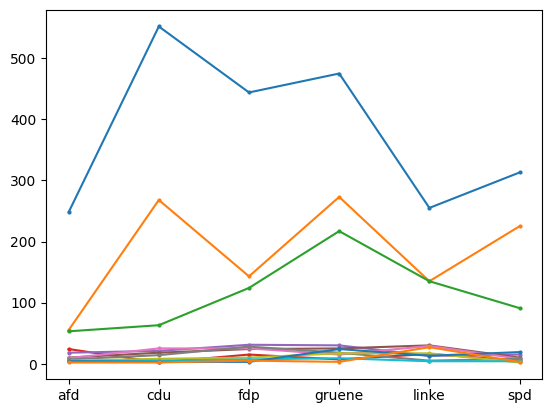

In [91]:
# Make slope plot
fig, ax = plt.subplots()
print(list(slope_df["Party"].unique()).insert(0, ""))
# plt.xticks([""] + slope_df["Party"].unique())
for lemma in slope_df["lemma"].unique():
    temp = slope_df[slope_df['lemma'] == lemma]
    plt.plot(temp.Party, temp.amount, marker='o', markersize=2)
    # start label
    # plt.text(temp.Party.values[0], temp.amount.values[0], lemma, ha='right', va='center')
    # # end label
    # plt.text(temp.Party.values[1]+0.4, temp.amount.values[1], lemma, ha='left', va='center')

In [105]:
for lemma in slope_df["lemma"].unique():
    temp = slope_df[slope_df['lemma'] == lemma]
    fig = px.line(temp, x="Party", y="amount" )
    fig.show()

In [103]:
plotly_df = concatenated_df.reset_index()
new_cols = list(plotly_df.columns)
new_cols[0] = "lemma"
plotly_df.columns = new_cols
plotly_df

,lemma,afd,cdu,fdp,gruene,linke,spd
0,Deutschland,248,552,444,475,255,313
1,Europa,55,268,143,273,135,225
2,EU,53,63,124,217,135,91
3,ezb,24,2,15,7,16,5
4,Türkei,18,21,31,30,13,15
5,USA,10,18,24,25,30,10
6,Nato,9,25,25,15,29,8
7,China,7,14,28,18,5,8
8,Berlin,5,8,10,17,17,2
9,Großbritannien,4,5,7,9,4,4


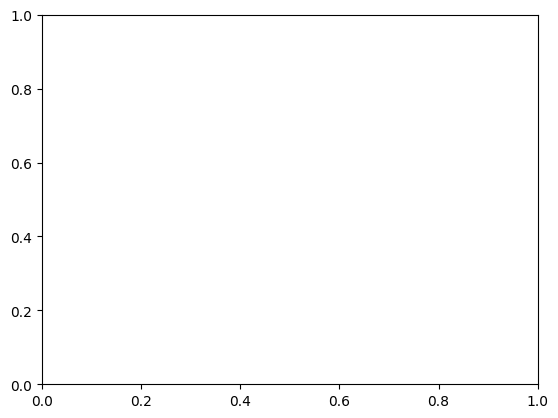

In [92]:
# Create a slope plot using Plotly Express
fig = px.line(df, x='Party', y=['Value_2019', 'Value_2020'], 
              labels={'variable': 'Year', 'value': 'Value'},
              title='Slope Plot of Value Changes Over Time',
              template='plotly_white')

# Show the plot
fig.show()